<a href="https://colab.research.google.com/github/Amit-Thomas/Wildlife-Surveillance-Project/blob/main/Wildlife_Surveillance_Frame_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

In [ ]:
with ZipFile('gdrive/MyDrive/Wildlife Surveillance Project/Videos/giraffe_zebra.zip', 'r') as zipObj:
    zipObj.extractall('videos')

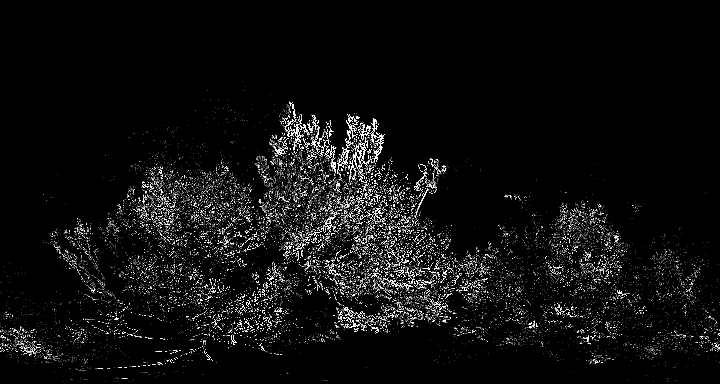

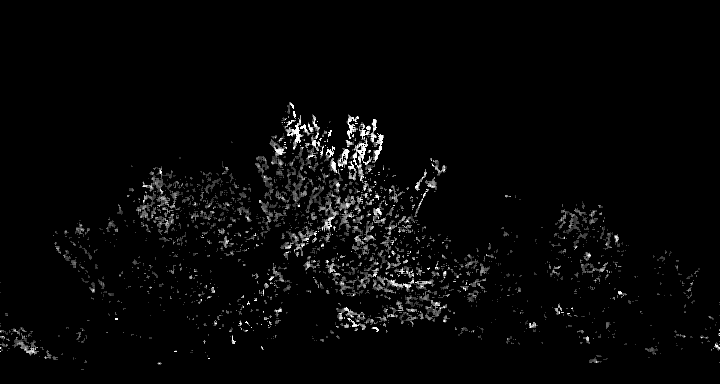

98512.53655613522 17604
5.596031388101297


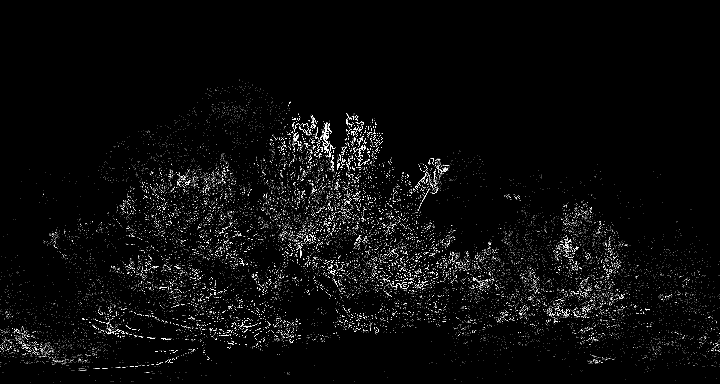

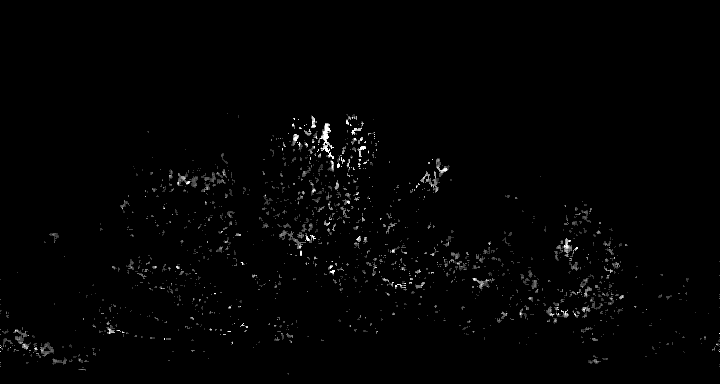

42919.63757113456 8507
5.045214243697491


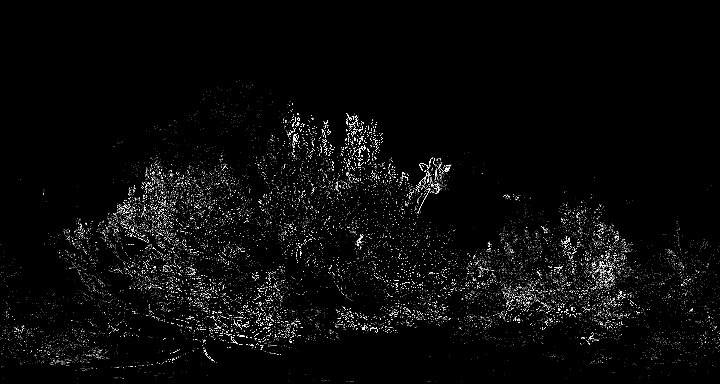

KeyboardInterrupt: ignored

In [ ]:
# Naive approach to background detection without using GMM

from google.colab.patches import cv2_imshow

import cv2
import numpy as np

ALPHA = 0.2
ALPHA2 = 0.7
BETA = 0.05
THRESHOLD = 15

def process_frame(frame):
  resized_frame = cv2.resize(frame, (720, 384))
  gray_image = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
  return gray_image

def median_filter(frame, radius):
  filtered_frame = np.zeros(frame.shape)
  frame_shape = frame.shape
  for i in range(frame_shape[0]):
    for j in range(frame_shape[1]):
      adjusted_radius = min([abs(i), abs(frame_shape[0] - i - 1), abs(j), abs(frame_shape[1] - j - 1), radius])
      filtered_frame[i][j] = np.median(frame[i-adjusted_radius:i + adjusted_radius + 1, j - adjusted_radius:j + adjusted_radius + 1])
  return filtered_frame

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/giraffe_zebra.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

fgbg = cv2.createBackgroundSubtractorMOG2()

ret, frame = cap.read()
accumulated_background = process_frame(frame)
difference_matrix = np.array(accumulated_background.shape)
accumulated_difference_matrix = np.zeros(accumulated_background.shape)

for j in range(400):
  ret, current_frame = cap.read()
  if(j%5 == 4):
    processed_current_frame = process_frame(current_frame)
    accumulated_background = (1 - ALPHA)*processed_current_frame + ALPHA*accumulated_background
    difference_matrix = abs(processed_current_frame - accumulated_background)
    accumulated_difference_matrix = (1 - ALPHA2)*difference_matrix + ALPHA2*accumulated_difference_matrix
    max_diff = np.max(difference_matrix)
    difference_matrix = np.array([[0 if difference < BETA*max_diff else difference for difference in row] for row in difference_matrix ])
    difference_matrix = (accumulated_difference_matrix>difference_matrix)*0+(accumulated_difference_matrix<difference_matrix)*difference_matrix



for i in range(80):
  ret, current_frame = cap.read()
  if(i%5 == 4):
    processed_current_frame = process_frame(current_frame)
    accumulated_background = (1 - ALPHA)*processed_current_frame + ALPHA*accumulated_background
    difference_matrix = abs(processed_current_frame - accumulated_background)
    accumulated_difference_matrix = (1 - ALPHA2)*difference_matrix + ALPHA2*accumulated_difference_matrix
    max_diff = np.max(difference_matrix)
    difference_matrix = np.array([[0 if difference < BETA*max_diff else difference for difference in row] for row in difference_matrix ])
    difference_matrix = (accumulated_difference_matrix>difference_matrix)*0+(accumulated_difference_matrix<difference_matrix)*difference_matrix
    cv2_imshow((difference_matrix*20))
    filtered_difference_matrix = median_filter(difference_matrix, 1)
    cv2_imshow(filtered_difference_matrix*20)
    print(np.sum(filtered_difference_matrix), np.count_nonzero(filtered_difference_matrix))
    energy = np.sum(filtered_difference_matrix)/np.count_nonzero(filtered_difference_matrix)
    print(energy)



  #fgmask = fgbg.apply(processed_current_frame)

#cv2_imshow(fgmask*processed_current_frame)

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
# GMM approach to background detection
# Zivkovic, Zoran, and Ferdinand Van Der Heijden. "Efficient adaptive density estimation per image pixel for the task of background subtraction." Pattern recognition letters 27.7 (2006): 773-780.

from google.colab.patches import cv2_imshow

import cv2
import numpy as np

MAX_MIXTURES = 4
MAX_VAR = 75
MIN_VAR = 4
INIT_VAR = 15
N_CHANNELS = 3
ALPHA = 0.05

IMG_X = 86
IMG_Y = 180
Tb = 4
Tg = 3
Cf = 0.05

def process_frame(frame):
  resized_frame = cv2.resize(frame, (IMG_Y, IMG_X))
  #gray_image = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
  return resized_frame

def maha_distance(pixel, mu, var):
  return np.sqrt(np.dot((pixel-mu), (pixel-mu))/var)

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/giraffe_zebra.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

ret, frame = cap.read()
resized_frame = process_frame(frame)


mixtures = np.zeros((IMG_X, IMG_Y, MAX_MIXTURES))
mixtures[:][:][0] = 1
n_mixtures = np.ones((IMG_X, IMG_Y))
mu_matrix = np.zeros((IMG_X, IMG_Y, N_CHANNELS, MAX_MIXTURES))
print(mu_matrix.shape, resized_frame.shape)
mu_matrix[:, :, :, 0] = resized_frame
var_matrix = np.ones((IMG_X, IMG_Y, MAX_MIXTURES))*INIT_VAR
background_matrix = np.zeros((IMG_X, IMG_Y))

for iter in range(3000):
  ret, frame = cap.read()
  if((iter%7 != 6) or (iter < 200)):
    continue
  resized_frame = process_frame(frame)

  for X in range(IMG_X):
    for Y in range(IMG_Y):
      max_pi = 0
      index = 0
      sortedIndices=np.argsort(mixtures[X,Y,:])
      sortedIndices=sortedIndices[::-1]
      totalWeights=0
      background_matrix[X, Y] = 1
      for idx in sortedIndices:
        if(totalWeights<1-Cf):
          distance = maha_distance(resized_frame[X, Y, :], mu_matrix[X, Y, :, idx], var_matrix[X, Y, idx])
          if(distance<Tb):
            background_matrix[X, Y] = 0
        totalWeights+=mixtures[X,Y,idx]

      for mixture in range(int((n_mixtures[X, Y]))):
        # Distance Calculation
        distance = maha_distance(resized_frame[X, Y, :], mu_matrix[X, Y, :, mixture], var_matrix[X, Y, mixture])
        if(distance < Tg):
          if(mixtures[X, Y, mixture] > max_pi):
            max_pi = mixtures[X, Y, mixture]
            index = mixture

      if(max_pi == 0):
        if(n_mixtures[X, Y] == MAX_MIXTURES):
          minimum = np.argmin(mixtures[X, Y, :])
        else:
          minimum = n_mixtures[X, Y]
          n_mixtures[X, Y] += 1
        mixtures[X, Y, int(minimum)] = ALPHA
        mu_matrix[X, Y, :, int(minimum)] = resized_frame[X, Y, :]
        var_matrix[X, Y, int(minimum)] = INIT_VAR
        mixtures[X, Y, :] = mixtures[X, Y, :]/np.sum(mixtures[X, Y, :])
      else:
        mixtures[X, Y, :] *= (1 - ALPHA)
        mixtures[X, Y, index] += ALPHA
        delta = resized_frame[X, Y, :] - mu_matrix[X, Y, : , index]
        mu_matrix[X, Y, :, index] = mu_matrix[X, Y, :, index] + (ALPHA/mixtures[X, Y, index])*(delta)
        var_matrix[X, Y, index] = var_matrix[X, Y, index] + (ALPHA/mixtures[X, Y, index])*(np.dot(delta, delta) - var_matrix[X, Y, index])
        var_matrix[X, Y, index] = np.max((var_matrix[X, Y, index], MIN_VAR))
        var_matrix[X, Y, index] = np.min((var_matrix[X, Y, index], MAX_VAR))
  print(iter)
  if(iter == 405):
    background_matrix[34, 100:113] = 1
    background_matrix[50, 100:113] = 1
    background_matrix[34:50, 100] = 1
    background_matrix[34:50, 113] = 1
    total_white = np.sum(background_matrix)
    inside_white = np.sum(background_matrix[34:50, 100:113])
    TPR = inside_white/(208)
    FPR = (total_white - inside_white)/(180*86 - 208)
    print(TPR, FPR)
    cv2_imshow(background_matrix*255)
#100, 120, 43 +- 15
#background_matrix[28, 100:120] = 1, background_matrix[58, 100:120], background_matrix[28:58, 100] = 1, background_matrix[28:58, 120] = 1
cv2_imshow(background_matrix*255)
cv2_imshow(resized_frame)




In [ ]:
# Thresholding functionality

from google.colab.patches import cv2_imshow

import cv2
import numpy as np

def process_frame(frame):
  resized_frame = cv2.resize(frame, (180, 86))
  #gray_image = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
  return resized_frame

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/giraffe_zebra.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")

fgbg = cv2.createBackgroundSubtractorMOG2()

ret, frame = cap.read()
resized_frame = process_frame(frame)
density = np.zeros((4, 8))
threshold=1000000
prev_threshold=1000000
for iter in range(3500):
  ret, frame = cap.read()
  if(iter%7 != 6):
    continue
  fgmask = fgbg.apply(process_frame(frame))

  #cv2_imshow(fgmask)
  if(iter%49!=6):
    continue
  fgmask = fgmask/255
  for l in range(4):
    for m in range(8):
      density[l, m] = np.sum(fgmask[l*21:(l+1)*21,m*22:(m+1)*22])
  max_index = np.argmax(density)
  max_val = np.max(density)
  if(max_val<threshold):
    threshold=0.9*max_val
    continue
  median = np.median(density)
  print(fgmask.shape)
  print(np.min([np.max([max_index//8, 0]), 1])*21, (np.min([np.max([max_index//8, 0]), 1])+3)*21, np.min([np.max([max_index%8, 0]), 5])*22, (np.min([np.max([(max_index%8), 0]), 5])+3)*22)
  #cv2_imshow(fgmask[np.min([np.max([max_index//8-1, 0]), 1])*21:(np.min([np.max([max_index//8-1, 0]), 1])+3)*21, np.min([np.max([max_index%8-1, 0]), 5])*22:(np.min([np.max([(max_index%8-1), 0]), 5])+3)*22]*255)
  if(iter > 800):
    cv2_imshow(frame[np.min([np.max([max_index//8-1, 0]), 4])*512:(np.min([np.max([max_index//8-1, 0]), 4])+3)*512, np.min([np.max([max_index%8-1, 0]), 8])*480:(np.min([np.max([(max_index%8-1), 0]), 8])+3)*480, :])

  cv2_imshow(fgmask*255)
  if(threshold>prev_threshold):
    prev_threshold=threshold
    threshold=0.9*max_val
  else:
    prev_threshold=threshold
    threshold=1.1*max_val

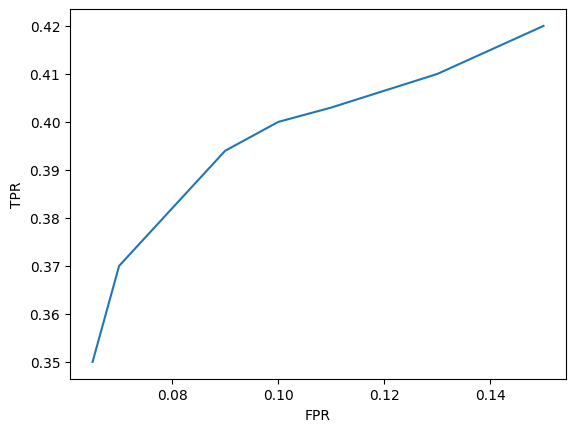

In [ ]:
# Receiver Operating Characteristic of Classifier

from matplotlib import pyplot as plt

TPR=[0.35, .37,.394,.4,.403,.41,.42]
FPR=[0.065, .07,.09,.1,.11,.13,.15]
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(FPR,TPR)